In [38]:
from dolfinx import log, default_scalar_type, io
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.fem.petsc import LinearProblem
import pyvista
import numpy as np
import ufl

from mpi4py import MPI
from dolfinx import fem, mesh, plot

from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import meshtags_from_entities

import matplotlib.pyplot as plt

# Mesh: Domain, Cell markers, Facet markers
L = 3
W = 0.2
domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0, 0, 0]), np.array([L, W, W])],[20, 6, 6], cell_type=mesh.CellType.hexahedron)

print(f"Domain topology = {domain.topology.dim}")

# Functional space
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

# Boundary conditions
def clamped_boundary_left(x):
    # function to locate the FACETS where x (x[0]) = 0
    return np.isclose(x[0], 0)

def clamped_boundary_right(x):
    # function to locate the FACETS where x (x[0]) = L
    return np.isclose(x[0], L)

# fdim = dimensionality where BCs are applied
fdim = domain.topology.dim - 1
boundary_facets_left = mesh.locate_entities_boundary(domain, fdim, clamped_boundary_left)

boundary_facets_right = mesh.locate_entities_boundary(domain, fdim, clamped_boundary_right)

print(f"fdim = {fdim}")

u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc_left = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets_left), V)
bc_right = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets_right), V)

# Traction
T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

# ds = integration measure, integral over the boundary 
ds = ufl.Measure("ds", domain=domain)

# Body forces
rho = 6000
g = 9.81
f = fem.Constant(domain, default_scalar_type((0,0,-rho*g)))

# Elasticity parameters
E = default_scalar_type(1.0e7)
nu = default_scalar_type(0.3)
mu = fem.Constant(domain, E / (2 * (1 + nu)))
lmbda = fem.Constant(domain, E * nu / ((1 + nu) * (1 - 2 * nu)))

# Variational formula
def sigma(u, lmbda, mu):
    return lmbda * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2*mu*epsilon(u)

def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.inner(sigma(u, lmbda, mu), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

problem = LinearProblem(a, L, bcs=[bc_left, bc_right], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# displacement, stress, strain
uh = problem.solve()
stressField = sigma(uh, lmbda, mu)
strainField = epsilon(uh)                

Domain topology = 3
fdim = 2


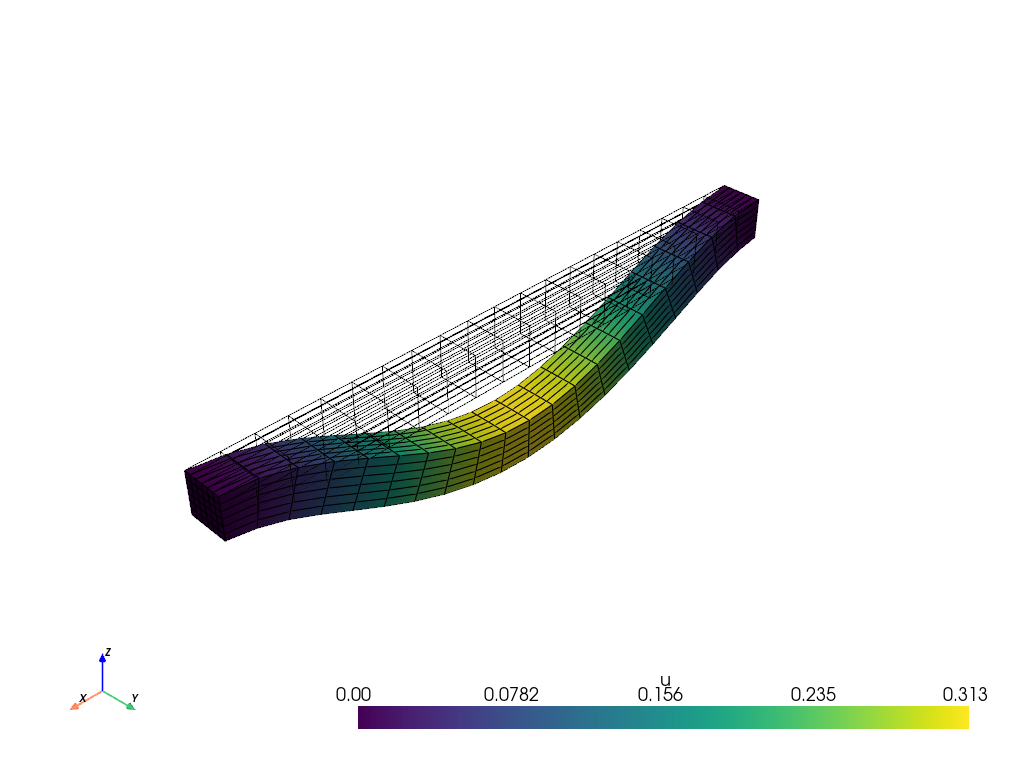

In [39]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")